In [1]:
from lgbmbuilder import lgbmbuilder as lb
import pandas as pd

### 1. Downloading data from Kaggle competition: Tabular Playground Series - May 2022
https://www.kaggle.com/competitions/tabular-playground-series-may-2022/data?select=train.csv

NOTE: First install kaggle api using below command to get the data. Also ensure you get a API token file from your kaggle account & place it in C:/Users/Username/.kaggle folder . You need this to use the kaggle package to get competition data directly :

In [ ]:
%%capture

##this installs the kaggle package required to download competition data directly
!pip install kaggle

In [ ]:
%%capture

##Downloading competition data
!kaggle competitions download -c tabular-playground-series-may-2022 -p data

In [ ]:

import os
from zipfile import ZipFile

##Extracting the zip file
filename=os.listdir("data/")[0]
with ZipFile("data/"+filename, 'r') as zip:
    zip.printdir()
    zip.extractall("data/")


## 2. Preprocessing data using `data_preparation()`:

The features of the `data_preparation()` function include:
* Lets users to specify either the path of the modelling data set or the user can just pass in a pandas dataframe directly
* Converting your string columns into categorical levels if you haven't already encoded them.
* Split your data into training, test & validation datasets whose proportions can be user-specified
* You can choose to save out your training, test & valid sets to the path specified.

The competition data we downloaded above has both training & test sets. Here we use just the training data to demonstrate the package features.
Lets specify to use 30% data for testing & 50% of that would be for validation data i.e 70% : train , 15% : test, 15%:validation data

In [2]:

data = lb.data_preparation(file_path = 'data/train.csv'
                     ,to_categorical = True    #convert object columns to categorical type
                     ,trainTestSplit=True
                     ,pc_testingData = 0.3 #Percent data used for testing your model(includes both test & validation set)
                     ,pc_tuningData = 0.5   #Percent data out of testing(specified in `pc_testingData` argument) that should be used for your validation dataset
                     ,show_proportions = True  #Whether to print the data proportions for train, test & valid
                     ,random_seed = 101      #To ensure split consistency
                     )

Reading data from path:  data/train.csv
Variables of `object` datatype found. Converting them to categorical
Creating training, test & validation sets
Modelling data proportions:
Training data: 70.0%
Testing data: 15.0%
Validation data: 15.0%


In [3]:
##Adding total unique characters in the column "f_27" as additional variable.
data["all"]["unique_characters"] =data["all"].f_27.apply(lambda s: len(set(s)))
data["train"]["unique_characters"] =data["train"].f_27.apply(lambda s: len(set(s)))
data["test"]["unique_characters"] =data["test"].f_27.apply(lambda s: len(set(s)))
data["valid"]["unique_characters"] =data["valid"].f_27.apply(lambda s: len(set(s)))


Now lets specify the input predictors we want to use in the model. Lets use all of them barring "id" & "target" variables

In [4]:
##Getting predictor column names
predictors=[col for col in data["all"].columns if col not in ["id", "target"]]

#The `create_data_structure()` function separates out the target variables from the predictor variables & stores metadata on categorical data of the training set 
dataDict = lb.create_data_structure(data=data, 
                                    predictor_cols=predictors
                                    ,response_col='target'
                                        ) 

# The `lgbm_data()` function converts the data into lgb Dataset format
lgbData = lb.lgbm_data(dataDict)


## 3. Hyperparameter tuning using the `hyperparameter_tuning()` function:

You can control how long you want to run the tuning process either by specifying the total trials or total maximum time (in hours).
* Set `n_jobs to -1` for max CPU usage. Default is using only 1 CPU core
* Use `early_stopping_rounds` & `num_boost_round` to control how large models are built to calculate the `metric`. Specifying more rounds will take more time, so either reduce `num_boost_round`(default 1000) or reduce `early_stopping_rounds`(default 10) or both to be more strict


In [5]:
%%time
tuned_params = lb.hyperparameter_tuning(lgbData, metric='binary_logloss'
                                        ,early_stopping_rounds=2
                                        ,num_boost_round=500
                                        ,n_trials=10
                                        ,n_jobs=-1
                                        ,max_runtime_hrs=None)

Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Using categorical_feature in Dataset.
Using categorical_feature in Dataset.
Using categorical_feature in Dataset.
Using categorical_feature in Dataset.
Using categorical_feature in Dataset.
Using categorical_feature in Dataset.
Using categorical_feature in Dataset.
categorical_column in param dict is overridden.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.


tuned_params: {'min_gain_to_split': 0.4269094954607028, 'learning_rate': 0.08840135314271964, 'num_leaves': 190, 'min_data_in_leaf': 442, 'lambda_l1': 1.3648352179293388, 'lambda_l2': 7.457808339309716, 'feature_fraction': 0.9738906992841394, 'bagging_fraction': 0.9030908177108171}
CPU times: total: 43min 3s
Wall time: 3min 8s


## 4. Building the model:
Instead of running the hyperparameter tuning separately, you can specify the `build_lgbm()` function that tunes & returns the final model. But here we use the former option.

In [6]:
parameters = {'boosting_type': 'gbdt', 
                 'objective': 'binary', 
                 'early_stopping_rounds': 10, 
                 'metric': 'binary_logloss',
                 'verbose': -1
                 }

#Adding in the tuned parameters
parameters.update(tuned_params)
parameters

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'early_stopping_rounds': 10,
 'metric': 'binary_logloss',
 'verbose': -1,
 'min_gain_to_split': 0.4269094954607028,
 'learning_rate': 0.08840135314271964,
 'num_leaves': 190,
 'min_data_in_leaf': 442,
 'lambda_l1': 1.3648352179293388,
 'lambda_l2': 7.457808339309716,
 'feature_fraction': 0.9738906992841394,
 'bagging_fraction': 0.9030908177108171}

In [7]:

model = lb.train_lgbm(lgbData
                     , parameters
                     , num_boost_round=1000
                     , do_param_tuning=False
                     , verbose_eval=-1)

Training until validation scores don't improve for 10 rounds


Found `early_stopping_rounds` in params. Will use it instead of argument


Early stopping, best iteration is:
[355]	train's binary_logloss: 0.195324	val's binary_logloss: 0.231574


## 5. Model performance:

You can use the performance() function to view:
* Feature importance
* SHAP values for all variables
* ROC & PR Curves on both test & validation sets
* Average vs Predicted plots for user-specified variables.
* Caliberation plots

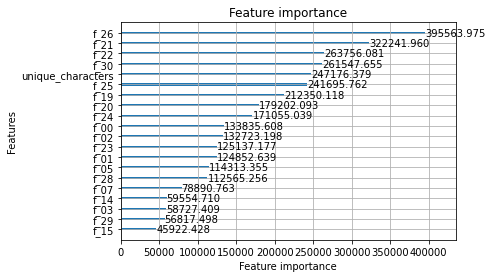

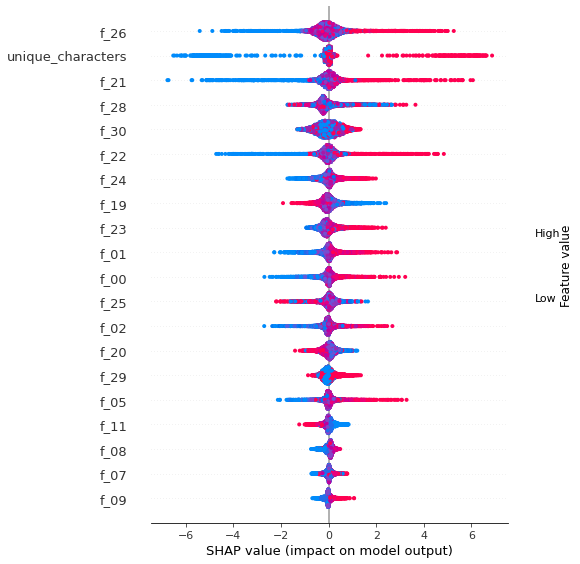

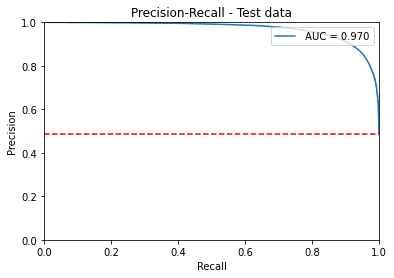

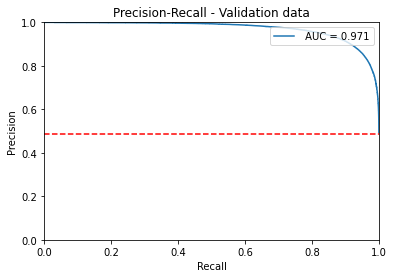

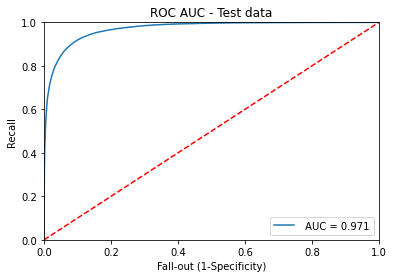

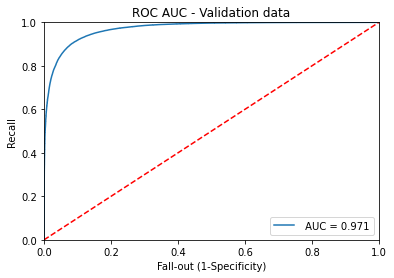

In [8]:
model = lb.performance(model,
                      predict_on=["test","valid"], 
                      feature_importance=True,
                      percent_data_shap=0.01,
                      pr_curve_test=True, pr_curve_valid=True,
                      roc_curve_test=True, roc_curve_valid=True,
                      caliberation_plot_test=False, caliberation_plot_valid=False,
                      actual_v_pred_test=False, actual_v_pred_valid=False )

You can also specify a list of variables for which you want to plot the actual vs predicted plots. Below we print the actual vs predicted plots for both the test & validation sets for as shown below. The `qcut` argument groups the variable into equal distribution buckets 

 `percent_data_shap` should be within 0 and 1. Skipping shap plot


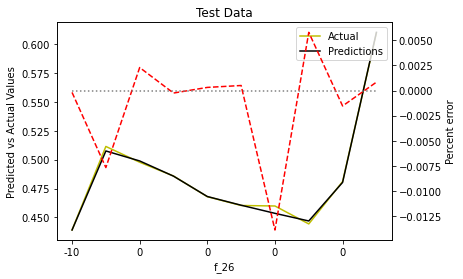

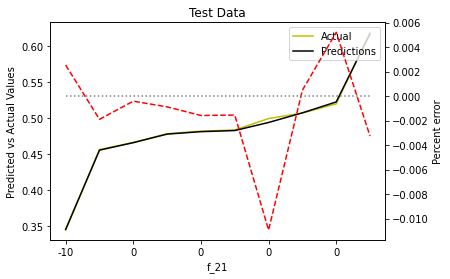

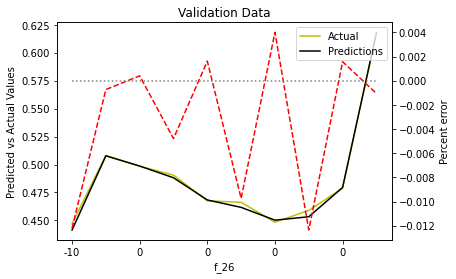

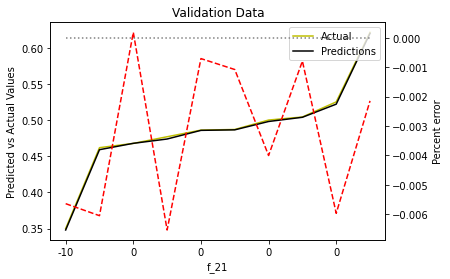

In [9]:
model = lb.performance(model, 
                       percent_data_shap=0,
                       actual_v_pred_test=True, actual_v_pred_valid=True,
                       qcut=True, 
                       variableList=["f_26","f_21"]
                            )

## 6. Comparing models:

You can build 2 separate models using this package & use the `model_comparison()` function to compare their performance against each other. Currently the function can compare:
* Error differences between models for training & test sets
* ROC Curve on test & validation sets
* Precision-Recall Curve on test & validation sets
* Caliberation plots for test & validation sets

Lets build another model using only the top 6 variables & see how the 2 models compare:

In [10]:
predictors2=["f_26","f_21","f_22","f_25","f_30", "unique_characters"]

dataDict2 = lb.create_data_structure(data=data,  predictor_cols=predictors2 , response_col='target' ) 
lgbData2 = lb.lgbm_data(dataDict2)

##We use the same tuned parameters as the previous model but change the learning rate & early_stopping_rounds
parameters2=parameters
parameters2["early_stopping_rounds"]=20
parameters2["learning_rate"]=0.01

model2 = lb.train_lgbm(lgbData2
                     , parameters
                     , num_boost_round=1000
                     , do_param_tuning=False
                     , verbose_eval=-1)

Found `early_stopping_rounds` in params. Will use it instead of argument
Using categorical_feature in Dataset.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[735]	train's binary_logloss: 0.532729	val's binary_logloss: 0.541497


Pct change in error metric on training data (Model2/Model1 - 1): 172.7541%
Pct change in error metric on testing data (Model2/Model1 - 1): 133.8329%


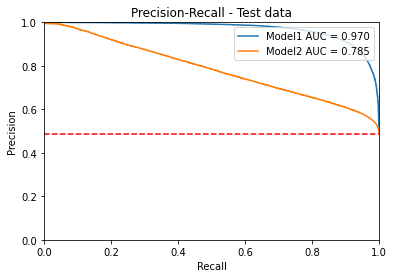

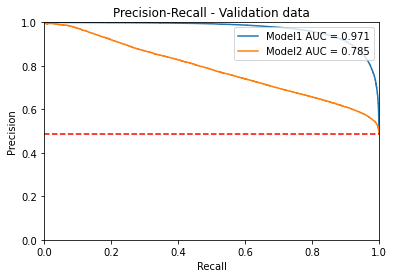

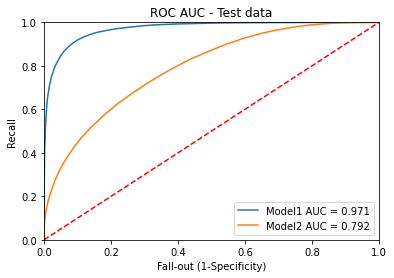

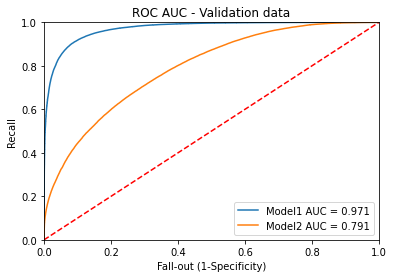

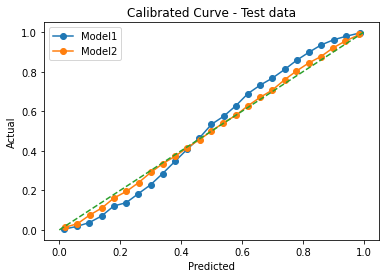

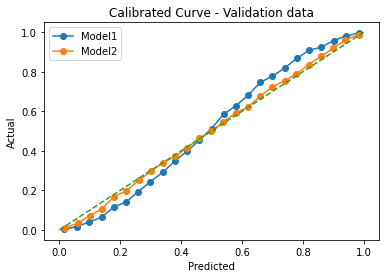

In [11]:
lb.model_comparison([model, model2], ['Model1', 'Model2'],
                  pc_error_diff_train=True, pc_error_diff_test=True,
                  pr_curve_diff_plt_test=True, pr_curve_plt_valid=True, 
                  roc_plot_test=True, roc_plot_valid=True,
                  calib_plot_test=True, calib_plot_valid=True)


### 7. Final Note
* Currently this package can only model regression & binary classification problems
* This package was designed to help with training some of my colleagues(non-data scientists) at work & for them to have a single generic code to model their data themselves as proof of concepts. So it lacks majority of advanced techniques you'd use while modelling. So dont expect a lot :-P